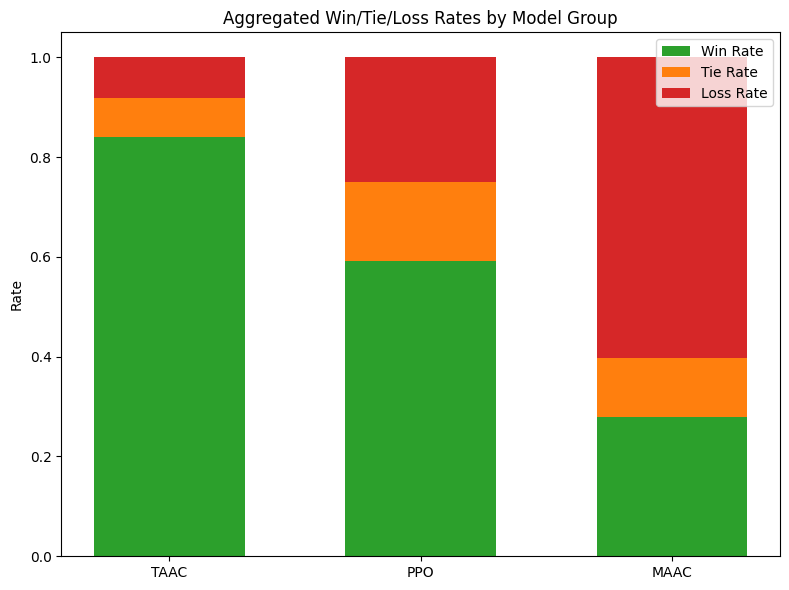

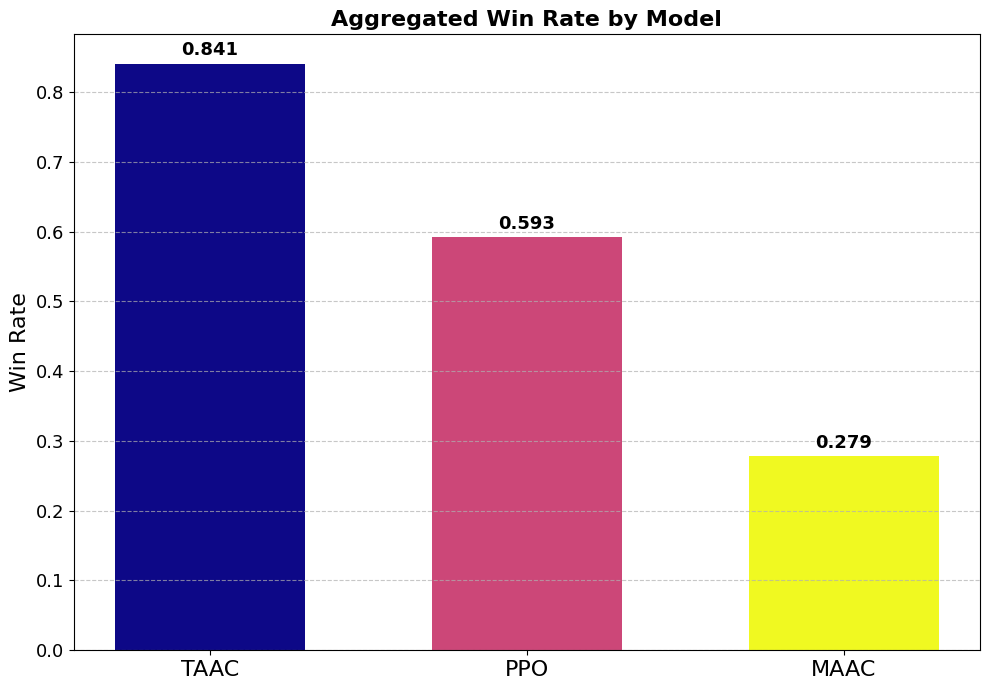

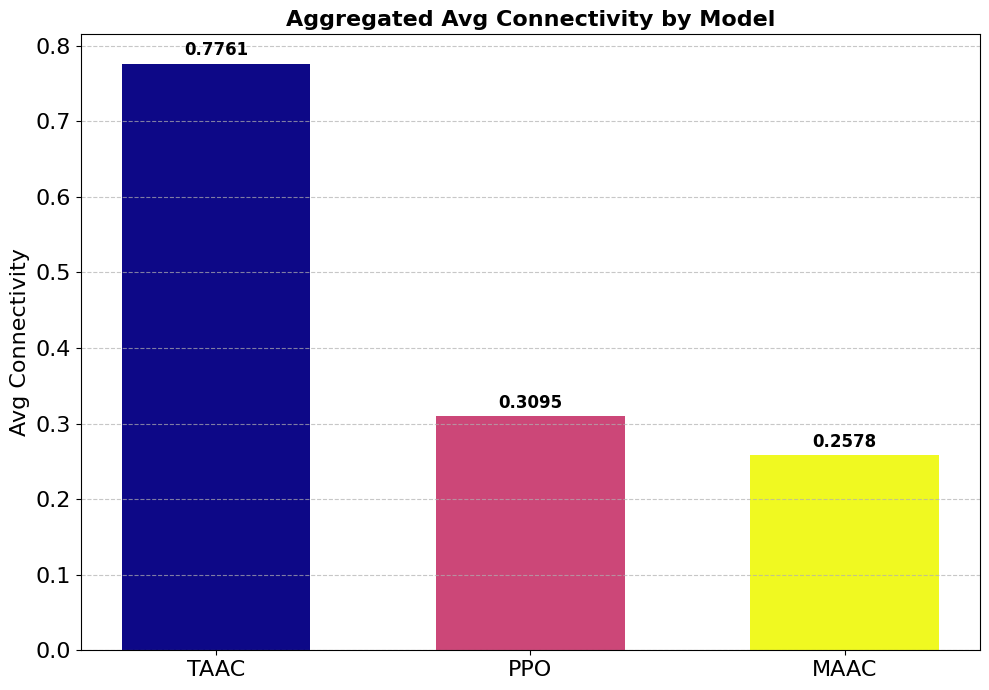

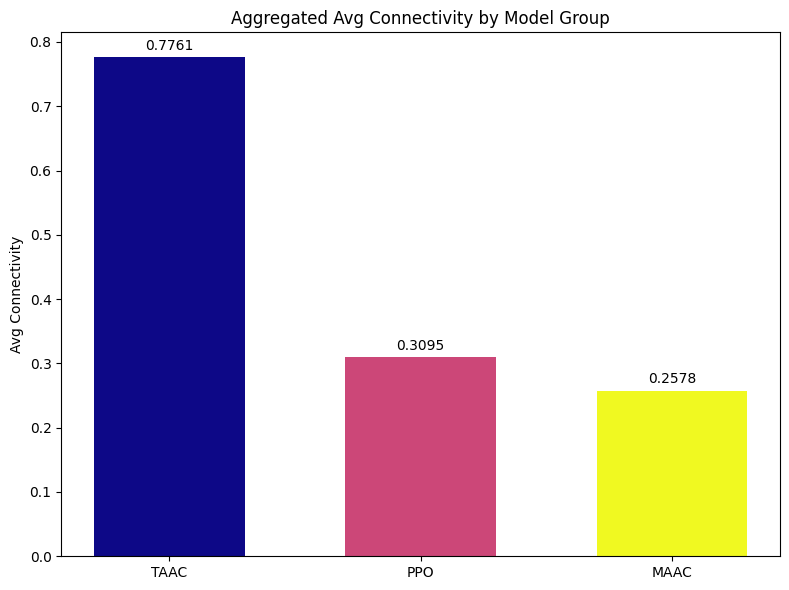

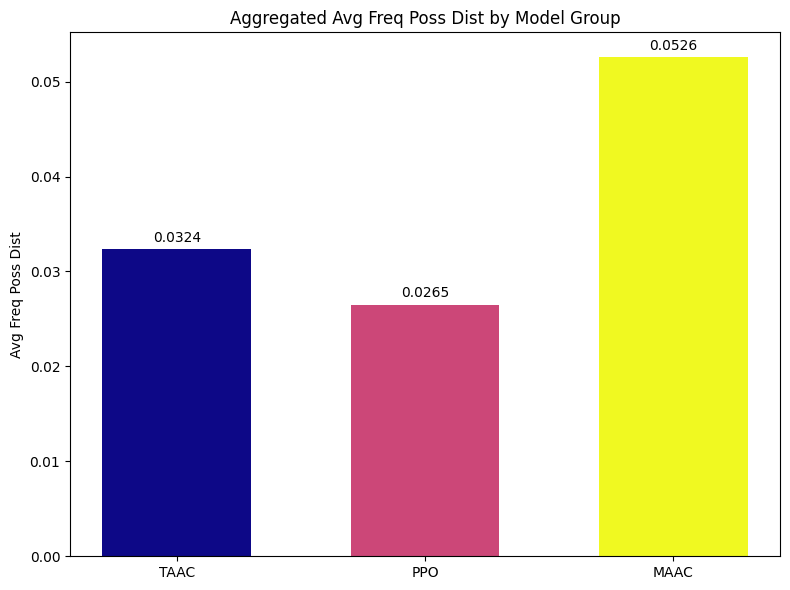

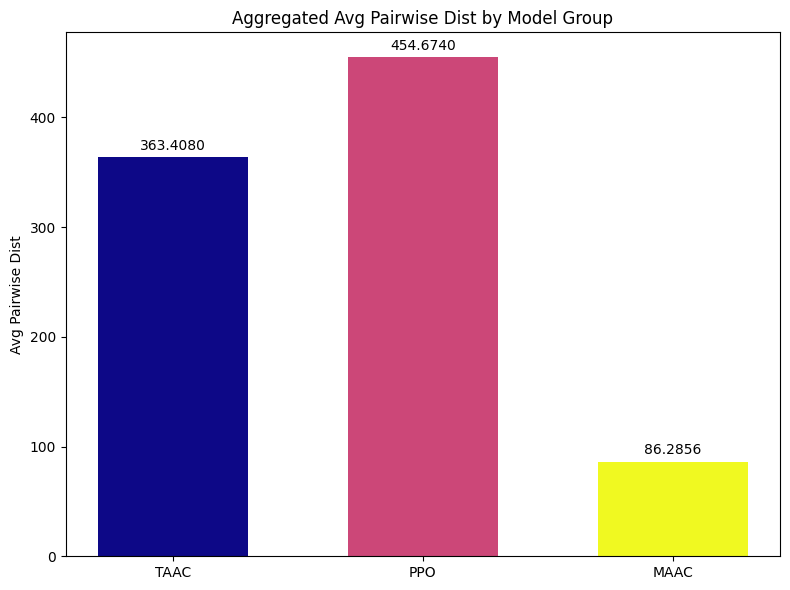

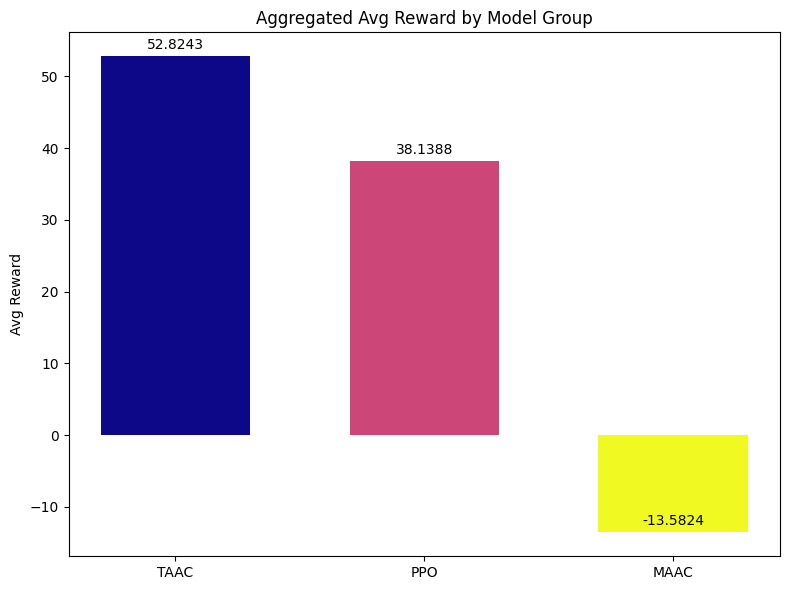

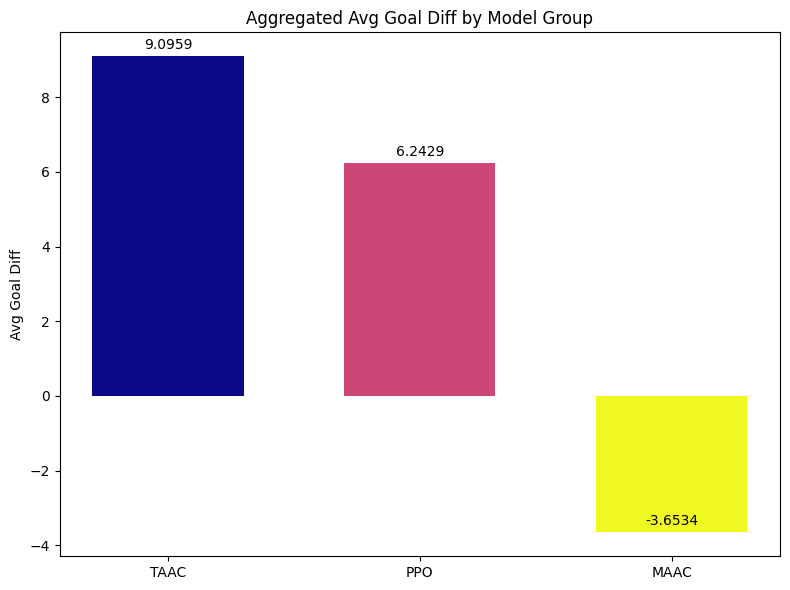

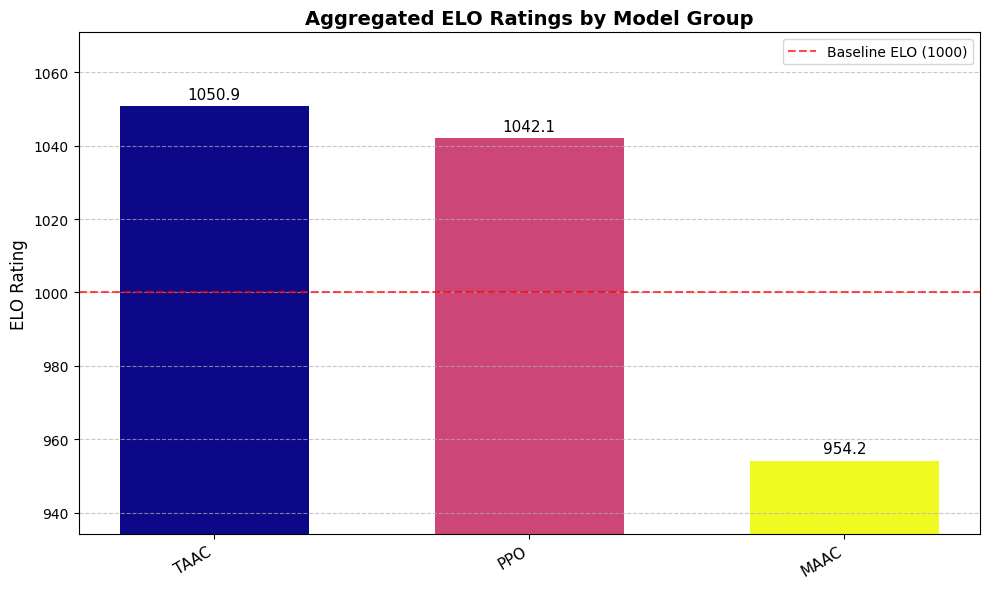

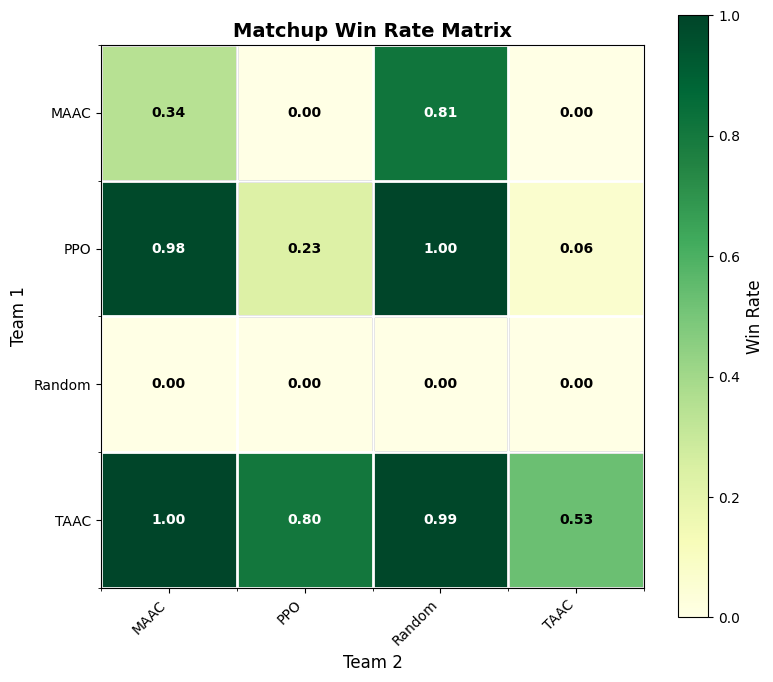

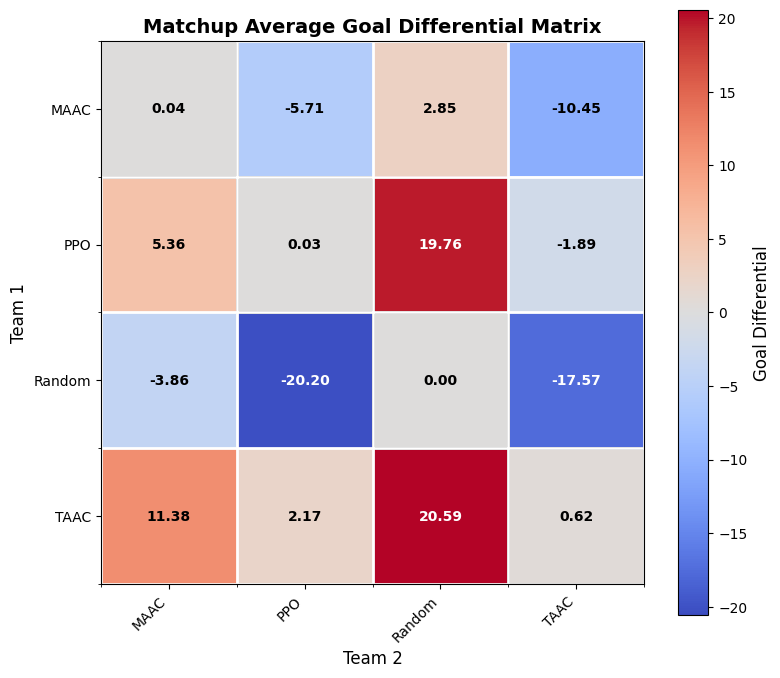

In [8]:
import re
import numpy as np
import matplotlib.pyplot as plt

# ================================
# New output (example run) as a multi-line string.
data = r'''
Individual statistics for TAAC:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
     0      256     0.84375     0.08594      0.07031             0.77954               0.03264              362.767       54.1603          9.36328  1050.99
     1      259     0.82625     0.07722      0.09653             0.7676                0.03303              362.036       50.596           8.63707  1050.71
     2      245     0.87755     0.05306      0.06939             0.78501               0.03112              366.365       56.6018          9.90612  1050.91
     3      249     0.81928     0.07229      0.10843             0.77108               0.03193              362.818       51.7939          8.8755   1050.16
     4      221     0.8371      0.10407      0.05882             0.77809               0.03331              363.144       50.8614          8.67421  1051.85

Individual statistics for PPO:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
     5      252     0.57143     0.19048      0.2381              0.30515               0.02631              455.845       36.4978          5.87302  1043.68
     6      235     0.60426     0.11915      0.2766              0.31552               0.02724              456.41        39.5599          6.4383   1041.39
     7      255     0.57647     0.16471      0.25882             0.30868               0.02666              452.899       37.1456          6.09412  1041.47
     8      240     0.57917     0.17083      0.25                0.30215               0.02698              453.699       35.4594          5.74583  1043.78
     9      245     0.63265     0.13878      0.22857             0.31651               0.0254               454.608       42.122           7.07755  1040.23

Individual statistics for MAAC:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
    10      277     0.26715     0.12274      0.61011             0.26587               0.05195              89.1984      -14.418          -3.86643  954.353
    11      247     0.2753      0.14575      0.57895             0.25457               0.05193              83.946       -12.6401         -3.42915  953.438
    12      234     0.24786     0.11111      0.64103             0.25038               0.05395              85.2462      -15.1746         -3.98718  952.53
    13      266     0.29699     0.12406      0.57895             0.25865               0.05175              85.5683      -12.6934         -3.46241  953.918
    14      257     0.3035      0.09339      0.60311             0.258                 0.05338              87.0837      -13.0578         -3.53307  956.541

Individual statistics for Random:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
    15      262           0     0.25191      0.74809             0.647                 0.01158              188.351      -44.8066         -11.4084  942.999
    16      229           0     0.27948      0.72052             0.6444                0.01049              186.805      -39.498          -10.2314  942.447
    17      258           0     0.25194      0.74806             0.64372               0.01121              188.113      -44.4053         -11.3217  943.429
    18      275           0     0.31273      0.68727             0.64905               0.0103               187.934      -40.7269         -10.5091  942.586
    19      238           0     0.20588      0.79412             0.64363               0.01219              186.924      -46.714          -11.8109  945.352

Aggregated statistics per model group:
Model      Total Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff    Avg ELO
-------  -------------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  ---------
TAAC              1230     0.84065     0.07805      0.0813              0.77614               0.0324              363.408        52.8243          9.09593   1050.92
PPO               1227     0.5925      0.15729      0.2502              0.30955               0.02651             454.674        38.1388          6.24287   1042.11
MAAC              1281     0.27869     0.11944      0.60187             0.25778               0.05256              86.2856      -13.5824         -3.6534     954.156

Matchup Win Rate Matrix (rows: team1, columns: team2):
           TAAC      PPO     MAAC    Random
------  -------  -------  -------  --------
TAAC    0.52878  0.80195  0.99684   0.99085
PPO     0.06431  0.23396  0.98131   1
MAAC    0        0        0.34483   0.81402
Random  0        0        0         0

Matchup Average Goal Differential Matrix (rows: team1, columns: team2):
             TAAC        PPO      MAAC    Random
------  ---------  ---------  --------  --------
TAAC      0.61511    2.16558  11.3797   20.5915
PPO      -1.89068    0.02642   5.35826  19.7606
MAAC    -10.4533    -5.71091   0.04215   2.85061
Random  -17.5678   -20.2017   -3.85855   0

'''

# ================================
# Parse the new output into sections.
sections = {}
current_section = None
section_lines = []
# We'll recognize four kinds of sections.
header_pattern = re.compile(
    r"^(Individual statistics for (.+):|Aggregated statistics per model group:|Matchup Win Rate Matrix|Matchup Average Goal Differential Matrix)",
    re.IGNORECASE
)

for line in data.splitlines():
    line = line.rstrip()
    if not line:
        continue
    match = header_pattern.match(line)
    if match:
        # If there is an active section, store it.
        if current_section is not None:
            sections[current_section] = "\n".join(section_lines)
            section_lines = []
        if match.group(1).startswith("Individual statistics for"):
            # e.g., "Individual statistics for TAAC:"; capture the model name.
            model_name = match.group(2).strip()
            current_section = f"individual_{model_name}"
        elif match.group(1).startswith("Aggregated statistics per model group"):
            current_section = "aggregated"
        elif match.group(1).startswith("Matchup Win Rate Matrix"):
            current_section = "matchup_win_rate"
        elif match.group(1).startswith("Matchup Average Goal Differential Matrix"):
            current_section = "matchup_goal_diff"
    else:
        if current_section:
            section_lines.append(line)
if current_section:
    sections[current_section] = "\n".join(section_lines)

# ================================
# Function to parse table sections (for individual and aggregated statistics)
def parse_table(text, convert_numbers=True):
    lines = [line for line in text.splitlines() if line.strip() != ""]
    if len(lines) < 3:
        return None, []
    header = lines[0]
    columns = re.split(r'\s{2,}', header.strip())
    # Skip the dashed separator (second line); data lines follow.
    data_lines = lines[2:]
    rows = []
    for row_line in data_lines:
        tokens = re.split(r'\s{2,}', row_line.strip())
        if len(tokens) != len(columns):
            continue
        row = {}
        for col, token in zip(columns, tokens):
            token = token.strip()
            if convert_numbers:
                if token.upper() == "N/A":
                    value = None
                else:
                    try:
                        # Try integer conversion first.
                        value = int(token)
                    except ValueError:
                        try:
                            value = float(token)
                        except ValueError:
                            value = token
                row[col] = value
            else:
                row[col] = token
        rows.append(row)
    return columns, rows

# Function to parse matrix sections (for the matchup matrices)
def parse_matrix(text):
    lines = [line for line in text.splitlines() if line.strip() != ""]
    if len(lines) < 3:
        return None, None, None
    header_line = lines[0]
    headers = re.split(r'\s{2,}', header_line.strip())
    data_lines = lines[2:]
    row_labels = []
    matrix_data = []
    for line in data_lines:
        tokens = re.split(r'\s{2,}', line.strip())
        if len(tokens) < 2:
            continue
        row_labels.append(tokens[0])
        row_vals = []
        for token in tokens[1:]:
            token = token.strip()
            if token.upper() == "N/A":
                row_vals.append(np.nan)
            else:
                try:
                    row_vals.append(float(token))
                except ValueError:
                    row_vals.append(np.nan)
        matrix_data.append(row_vals)
    return headers, row_labels, np.array(matrix_data)

# ================================
# Parse individual statistics sections.
individual_stats = {}
for key, text in sections.items():
    if key.startswith("individual_"):
        # key is like "individual_HUGO"
        cols, rows = parse_table(text)
        individual_stats[key.split("_", 1)[1]] = {
            "columns": cols,
            "rows": rows
        }

# Parse aggregated statistics.
aggregated_stats = None
if "aggregated" in sections:
    cols, rows = parse_table(sections["aggregated"])
    aggregated_stats = {
        "columns": cols,
        "rows": rows
    }

# Parse matchup matrices.
matchup_win_rate = None
if "matchup_win_rate" in sections:
    headers, row_labels, matrix = parse_matrix(sections["matchup_win_rate"])
    matchup_win_rate = {
        "headers": headers,
        "row_labels": row_labels,
        "data": matrix
    }

matchup_goal_diff = None
if "matchup_goal_diff" in sections:
    headers, row_labels, matrix = parse_matrix(sections["matchup_goal_diff"])
    matchup_goal_diff = {
        "headers": headers,
        "row_labels": row_labels,
        "data": matrix
    }

# ================================
# Visualizations for Aggregated Statistics per model group.
if aggregated_stats:
    # Create a dictionary keyed by model (first column "Model")
    agg_data = {}
    for row in aggregated_stats["rows"]:
        model = row["Model"]
        agg_data[model] = row
    models_agg = list(agg_data.keys())
    
    # Extract metrics.
    win_rates = [agg_data[m]["Win Rate"] for m in models_agg]
    tie_rates = [agg_data[m]["Tie Rate"] for m in models_agg]
    loss_rates = [agg_data[m]["Loss Rate"] for m in models_agg]
    connectivity_agg = [agg_data[m]["Avg Connectivity"] for m in models_agg]
    poss_dist_agg = [agg_data[m]["Avg Freq Poss Dist"] for m in models_agg]
    pairwise_agg = [agg_data[m]["Avg Pairwise Dist"] for m in models_agg]
    reward_agg = [agg_data[m]["Avg Reward"] for m in models_agg]
    goal_diff_agg = [agg_data[m]["Avg Goal Diff"] for m in models_agg]
    elo_agg = [agg_data[m]["Avg ELO"] for m in models_agg]
    
    x = np.arange(len(models_agg))
    bar_width = 0.6
    colors = plt.cm.plasma(np.linspace(0, 1, len(models_agg)))
    
    # -- Aggregated Stacked Bar Plot for Win/Tie/Loss Rates --
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(x, win_rates, bar_width, label='Win Rate', color='tab:green')
    ax.bar(x, tie_rates, bar_width, bottom=np.array(win_rates), label='Tie Rate', color='tab:orange')
    ax.bar(x, loss_rates, bar_width, bottom=np.array(win_rates)+np.array(tie_rates), label='Loss Rate', color='tab:red')
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Rate")
    ax.set_title("Aggregated Win/Tie/Loss Rates by Model Group")
    ax.legend()
    plt.tight_layout()
    plt.show()

        # -- Aggregated Win Rate Plot (not stacked) --
    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.bar(x, win_rates, width=bar_width, color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg, fontsize=16)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylabel("Win Rate", fontsize=16)
    ax.set_title("Aggregated Win Rate by Model", fontsize=16, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Connectivity --
    fig, ax = plt.subplots(figsize=(10, 7))
    bars = ax.bar(x, connectivity_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel("Avg Connectivity", fontsize=16)
    ax.set_title("Aggregated Avg Connectivity by Model", fontsize=16, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', 
                    fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Connectivity --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, connectivity_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Connectivity")
    ax.set_title("Aggregated Avg Connectivity by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Freq Poss Dist --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, poss_dist_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Freq Poss Dist")
    ax.set_title("Aggregated Avg Freq Poss Dist by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Pairwise Dist --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, pairwise_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Pairwise Dist")
    ax.set_title("Aggregated Avg Pairwise Dist by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Reward --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, reward_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Reward")
    ax.set_title("Aggregated Avg Reward by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Goal Diff --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, goal_diff_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Goal Diff")
    ax.set_title("Aggregated Avg Goal Diff by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg ELO --
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x, elo_agg, width=bar_width, color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=11)
    
    # Set y-axis to start from a value slightly below the minimum
    y_min = max(900, min(elo_agg) - 20)  # Start at 900 or lower if needed
    y_max = max(elo_agg) + 20
    ax.set_ylim(y_min, y_max)
    
    # Add a horizontal line showing the baseline ELO value (typically 1000)
    ax.axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='Baseline ELO (1000)')
    
    ax.set_ylabel('ELO Rating', fontsize=12)
    ax.set_title('Aggregated ELO Ratings by Model Group', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg, rotation=30, ha='right', fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()
# ================================
# Visualization for the Matchup Matrices as Heatmaps.
def plot_heatmap(matrix_dict, title, fmt="{:.2f}"):
    headers = matrix_dict["headers"]
    row_labels = matrix_dict["row_labels"]
    data = matrix_dict["data"]
    
    # Make sure all models are included in both rows and columns
    all_models = sorted(set(row_labels).union(set(headers[0:])))
    
    # Create a complete matrix with all models (fill with NaN for missing values)
    full_data = np.full((len(all_models), len(all_models)), np.nan)
    
    # Map from model name to row/column index in the full matrix
    model_indices = {model: i for i, model in enumerate(all_models)}
    
    # Fill in the data we have
    for i, row_model in enumerate(row_labels):
        for j, col_model in enumerate(headers[0:]):
            row_idx = model_indices[row_model]
            col_idx = model_indices[col_model]
            if not np.isnan(data[i, j]):
                full_data[row_idx, col_idx] = data[i, j]
    
    # Plot the full matrix
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Choose appropriate colormap and normalization
    if "Win Rate" in title:
        cmap = 'YlGn'
        vmin, vmax = 0, 1  # Win rates should be between 0 and 1
    else:
        cmap = 'coolwarm'
        # Symmetric colormap around 0 for goal differential
        abs_max = np.nanmax(np.abs(full_data))
        vmin, vmax = -abs_max, abs_max
    
    # Create the heatmap
    im = ax.imshow(full_data, cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
    
    # Set axis labels
    ax.set_xticks(np.arange(len(all_models)))
    ax.set_yticks(np.arange(len(all_models)))
    ax.set_xticklabels(all_models, rotation=45, ha="right")
    ax.set_yticklabels(all_models)
    
    # Add grid lines
    ax.set_xticks(np.arange(-.5, len(all_models), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(all_models), 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    
    # Add title and axis labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Team 2", fontsize=12)
    ax.set_ylabel("Team 1", fontsize=12)
    
    # Annotate each cell with its value
    for i in range(len(all_models)):
        for j in range(len(all_models)):
            val = full_data[i, j]
            if np.isnan(val):
                text = "N/A"
                color = "gray"
            else:
                text = fmt.format(val)
                # Choose text color based on background darkness
                if "Win Rate" in title:
                    color = "black" if val < 0.7 else "white"
                else:
                    color = "black" if abs(val) < abs_max * 0.7 else "white"
            
            # Highlight diagonal (self-play) cells
            if i == j:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, 
                                          edgecolor='black', lw=2))
                                          
            ax.text(j, i, text, ha="center", va="center", 
                   color=color, fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("Win Rate" if "Win Rate" in title else "Goal Differential", fontsize=12)
    
    plt.tight_layout()
    plt.show()

if matchup_win_rate:
    plot_heatmap(matchup_win_rate, "Matchup Win Rate Matrix", fmt="{:.2f}")

if matchup_goal_diff:
    plot_heatmap(matchup_goal_diff, "Matchup Average Goal Differential Matrix", fmt="{:.2f}")